In [2]:
# 导入包
import numpy as np # 科学计算的python库
import matplotlib.pyplot as plt # 二维图像库
import h5py # 一个从h5文件加载数据集的库
import scipy # 用来在最后测试模型
from PIL import Image # 同上
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

y[1], it's a cat' picture.


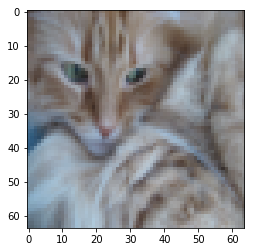

In [6]:
# 加载数据集， 先要观察一下数据

train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()
"""
在变量添加后缀“_orig”用来表示原生数据，将用来预测它们
y表示标签，所以我们不需要预测它们
"""
index = 2
train_x = train_x_orig[index] # 数据是64x64x3的图片描述。宽高64，每位有3位rbg描述
plt.imshow(train_x)
# squeeze:: 将数组的形状中删除单维的条目，把shape为1的维度去掉
print("y" + str(train_y[:, index])  + ", it's a " + classes[np.squeeze(train_y[:, index])].decode("utf-8") + "' picture.")

In [69]:
# 许多软件在深度学习中的问题是矩阵/向量的大小不合适，所以需要注意矩阵/向量的大小
"""
m_train :: 训练样例
m_test :: 测试样例
num_px :: 训练图片的宽高
(209, 64, 64, 3)
有209个数据，每个数据是64x64的大小，每个像素包含了三个数据(rbg)
"""

m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
num_px = train_x_orig.shape[1]

In [37]:
"""
方便起见，应该将图片的矩阵转换一下 from (num_px, num_px, 3) -> (num_px*num_px*3, 1)
shape :: (height, width)
当 reshape 参数为-1 时， 会根据矩阵剩余的维度计算
例如 
(3, 2, 2) -> reshape (3, -1) -> (3, 4)
(3, 2, 2) -> reshape (-1) -> (12, 1)
(3, 2, 2) -> reshape (-1, 2) -> (6, 2)
(3, 2, 2) -> reshape (-1, 2, 3) -> (2, 2, 3)
"""
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T # reshape之后转置是为何 : 应该是为了和y对应
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
print("train_x_flatten shape: " + str(train_x_flatten.shape))
print("train_y shape: " + str(train_y.shape))
print("test_x_flatten shape: " + str(test_x_flatten.shape))
print("test_y shape: "+ str(test_y.shape))
# 验证一下
print("sanity check after reshaping: " + str(train_x_flatten[0: 5, 0]))

train_x_flatten shape: (12288, 209)
train_y shape: (1, 209)
test_x_flatten shape: (12288, 50)
test_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [12]:
# 归一化处理
train_x = train_x_flatten/255
test_x = test_x_flatten/255

In [64]:
# 一般的结构学习算法

# 逻辑回归实际上是非常简单的神经网络
"""
构建一个神经网络的主要步骤有：
1. 定义一个模型的结构(例如输入的特征数)
2. 初始化模型的参数
3. 循环如下
    ·计算最近的损失函数(向前传播)
    ·计算最近的梯度(向后传播)
    ·更新参数{梯度下降法}
计算的过程中，会用到sigmoid函数，来完成预测
"""

def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

def initialize_with_zeros(dim: int) -> tuple:
    w = np.zeros((dim, 1))
    b = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return (w, b)

"""
矩阵的乘法：
m, x 行数
n, y 列数
[m*n] * [x*y] -> [m*y]
"""
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    # 将矩阵按照矩阵的规则相乘
    # y hat
    A = sigmoid(np.dot(w.T, X) + b) # 先计算出来目标(y hat)再计算损失函数相关
    # log 计算以e为底的指数
    cost = -1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    dw = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    # 将维度为1的去掉
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    grads = {
        "dw": dw,
        "db": db
    }
    return (grads, cost)

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=True):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads['dw']
        db = grads['db']
        # 更新参数
        # 这里是 减号 的原因是： 如果斜率为正，则说明处于高于”碗底“的地方，需要继续减小损失函数，加减用斜率的正负来调整
        w = w - dw * learning_rate
        b = b - db * learning_rate
        if i % int(num_iterations/10) == 0:
            if print_cost:
                print("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
    params = {
        'w': w,
        'b': b
    }
    grads = {
        'dw': dw,
        'db': db
    }
    return params, grads, costs

def predict(w, b, X):
    m = X.shape[1]
    yhat = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        if A[0, i] <= 0.5:
            yhat[0, i] = 0
        else:
            yhat[0, i] = 1
    assert(yhat.shape == (1, m))
    return yhat

In [65]:
w, b = initialize_with_zeros(train_x.shape[0])
params, grads, costs = optimize(w, b, train_x, train_y, 2000, 0.005)
# 预测

Cost after iteration 0: 0.693147
Cost after iteration 200: 0.466949
Cost after iteration 400: 0.331463
Cost after iteration 600: 0.279880
Cost after iteration 800: 0.242941
Cost after iteration 1000: 0.214820
Cost after iteration 1200: 0.192544
Cost after iteration 1400: 0.174399
Cost after iteration 1600: 0.159305
Cost after iteration 1800: 0.146542


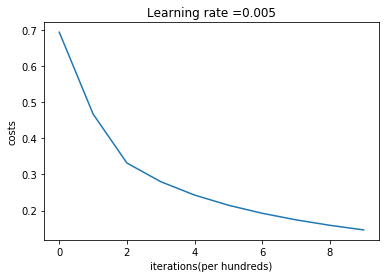

In [68]:
w = params['w']
b = params['b']
yhat = predict(w, b, test_x)
costs = np.squeeze(costs)
plt.plot(costs)
plt.xlabel('iterations(per hundreds)')
plt.ylabel('costs')
plt.title("Learning rate =" + str(0.005))
plt.show()